In [1]:
import os 
import numpy as np
import pandas as pd
import pickle 
from astropy.table import Table

In [2]:
import sklearn
print(sklearn.__version__)

0.23.0


In [3]:
train_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_HEAD.FITS'
train_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/train_final_master_PHOT.FITS'
test_data_head_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_HEAD.FITS'
test_data_phot_path = '/sps/lsst/users/bbiswas/data/kilonova_datasets/test_final_master_PHOT.FITS'

In [4]:
df_header = Table.read(train_data_head_path, format='fits').to_pandas()
df_phot = Table.read(train_data_phot_path, format='fits').to_pandas()

In [5]:
from kndetect.utils import load_pcs, get_event_type, get_data_dir_path
from kndetect.features import extract_features_all_lightcurves
from kndetect.training import append_y_true_col

In [6]:
pcs = load_pcs()
data_dir = get_data_dir_path()

In [7]:
use_already_trained_features = True
use_already_trained_models = False
mimic_alerts = True
save_data = True

if mimic_alerts:
    sub_directory = "partial"
else: 
    sub_directory = "complete"

In [8]:
if use_already_trained_features:
    train_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "train_features.csv"),index_col=0)

else:
    train_features_df = extract_features_all_lightcurves(df_phot, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    train_features_df = append_y_true_col(features_df=train_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [9]:
train_features_df

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred,y_score
0,0.632028,0.008088,0.366976,0.958710,230.670456,0.727304,-0.098875,0.355660,1.610522,373.748047,1757,57661.2736,150,150: KN GW170817,True,True,0.842749
1,0.782480,0.268593,0.149629,0.466376,427.853790,1.060051,-0.059434,-0.106277,1.989556,788.683228,6415,57461.4561,141,141: 91BG,False,False,0.013516
2,0.750644,0.087323,0.172727,0.937126,270.629425,0.876449,0.080352,0.104214,0.825639,401.693390,7707,57484.2005,103,103: Core collapse Type Ibc,False,False,0.057139
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.712076,0.151259,0.263020,1.071781,534.019775,8267,57671.3147,151,151: KN Karsen 2017,True,False,0.284338
4,1.028029,-0.020704,0.038843,0.993747,263.286224,0.000000,0.000000,0.000000,0.000000,0.000000,12578,57517.4403,102,102: MOSFIT-Ibc,False,False,0.056763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22275,1.088962,-0.014523,0.106654,1.693484,888.318420,1.205512,-0.059662,0.725981,1.578576,666.974243,137062467,57565.3666,112,112: Core collapse Type II,False,False,0.000006
22276,0.978098,-0.118905,-0.022548,1.571079,1141.677979,1.038589,-0.084343,0.017370,1.344228,1213.934937,137071784,57690.5287,170,170: AGN,False,False,0.001204
22277,1.038554,-0.092552,0.148199,1.327237,295.870941,0.990183,-0.038269,0.027255,0.717529,408.148193,137071978,57621.3001,143,143: Iax,False,False,0.000880
22278,0.622255,-0.028716,0.439814,1.676503,525.301697,0.000000,0.000000,0.000000,0.000000,0.000000,137079473,57493.3158,151,151: KN Karsen 2017,True,True,0.694343


# Now Train the classifier

In [10]:
from kndetect.training import train_classifier

In [11]:
if not use_already_trained_models:
    clf, features_df = train_classifier(train_features_df)
    if save_data:
        with open(os.path.join(data_dir, "models", sub_directory + ".pkl"), 'wb') as files:
            pickle.dump(clf, files)
else:
    from kndetect.predict import load_classifier
    clf = load_classifier(sub_directory + ".pkl")

In [12]:
# Generate Test features and Predict probabilities

In [13]:
df_header_test = Table.read(test_data_head_path, format='fits').to_pandas()
df_phot_test = Table.read(test_data_phot_path, format='fits').to_pandas()

In [14]:
if use_already_trained_features:
    test_features_df = pd.read_csv(os.path.join(data_dir, sub_directory, "test_features.csv"),index_col=0)

else:
    test_features_df = extract_features_all_lightcurves(df_phot_test, 
                                                         "SNID", 
                                                         pcs, 
                                                         [b'g', b'r'],
                                                         mimic_alerts=mimic_alerts)
    test_features_df = append_y_true_col(features_df=test_features_df,
                                          prediction_type_nos=[149, 150, 151],
                                          meta_df = df_header_test, 
                                          meta_key_col_name = "SNID",
                                          meta_type_col_name = "SNTYPE")

In [15]:
from kndetect.predict import load_classifier, predict_kn_score

In [16]:
probabilities, filtered_indices = predict_kn_score(clf, test_features_df)

In [17]:
test_features_df['y_pred_score'] = probabilities.T[1]

In [18]:
filtered=test_features_df[filtered_indices]

In [19]:
y_true = filtered["y_true"] == 1
y_pred = filtered["y_pred_score"]>0.5

In [20]:
y_true_train = features_df["y_true"]
y_pred_train = features_df["y_pred"]

print("train statistics:")
print("\ntotal number of events: " + str(len(y_true_train)))
print("total number of KN: " + str(np.sum(y_true_train)))
print("total number of non KN: " + str(np.sum(~y_true_train))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true_train&y_pred_train)))
print("False Positive : {fp}".format(fp = np.sum(~y_true_train&y_pred_train)))
print("True negative : {tn}".format(tn = np.sum(~y_true_train&~y_pred_train)))
print("False negative : {fn}".format(fn = np.sum(y_true_train&~y_pred_train)))


train statistics:

total number of events: 22280
total number of KN: 3280
total number of non KN: 19000

True Positive : 2427
False Positive : 345
True negative : 18655
False negative : 853


In [21]:
features_df[features_df["type"]==151]

,coeff1_g,coeff2_g,coeff3_g,residuo_g,maxflux_g,coeff1_r,coeff2_r,coeff3_r,residuo_r,maxflux_r,key,current_dates,type,type_names,y_true,y_pred,y_score
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.712076,0.151259,0.263020,1.071781,534.019775,8267,57671.3147,151,151: KN Karsen 2017,True,False,0.345035
10,0.505075,0.118589,0.220240,5.501735,1721.492798,0.633226,0.109101,0.277846,4.835148,1562.443726,22525,57490.2542,151,151: KN Karsen 2017,True,True,0.727759
33,0.000000,0.000000,0.000000,0.000000,0.000000,0.856746,-0.185463,0.481298,2.013971,787.250732,116775,57693.1267,151,151: KN Karsen 2017,True,True,0.754354
51,0.773916,-0.097459,0.293853,2.962483,408.353363,0.000000,0.000000,0.000000,0.000000,0.000000,207459,57436.5012,151,151: KN Karsen 2017,True,True,0.559120
58,0.836529,0.154053,0.158703,1.939368,926.869141,0.874804,0.136779,0.117946,1.356504,1061.635254,231140,57630.3144,151,151: KN Karsen 2017,True,True,0.595922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22253,0.000000,0.000000,0.000000,0.000000,0.000000,0.644339,-0.109632,0.409417,1.036162,213.613358,136959425,57621.3330,151,151: KN Karsen 2017,True,False,0.413814
22255,0.865400,0.120031,0.145721,2.322712,1708.722778,0.000000,0.000000,0.000000,0.000000,0.000000,136970486,57653.3835,151,151: KN Karsen 2017,True,False,0.386055
22258,0.935683,0.125356,0.074704,0.946414,227.239624,0.672429,0.092215,-0.501572,0.973459,382.670197,136976627,57649.2894,151,151: KN Karsen 2017,True,True,0.572839
22273,0.893744,0.144711,0.097800,3.876916,4120.973633,1.010048,0.062081,-0.002372,1.646331,5347.779297,137057324,57630.3980,151,151: KN Karsen 2017,True,False,0.489071


In [22]:
print("test statistics:")
print("\ntotal number of events: " + str(len(y_true)))
print("total number of KN: " + str(np.sum(y_true)))
print("total number of non KN: " + str(np.sum(~y_true))) 

print("\nTrue Positive : {tp}".format(tp = np.sum(y_true&y_pred)))
print("False Positive : {fp}".format(fp = np.sum(~y_true&y_pred)))
print("True negative : {tn}".format(tn = np.sum(~y_true&~y_pred)))
print("False negative : {fn}".format(fn = np.sum(y_true&~y_pred)))

test statistics:

total number of events: 19450
total number of KN: 2005
total number of non KN: 17445

True Positive : 1223
False Positive : 598
True negative : 16847
False negative : 782


In [23]:
if save_data:
    train_features_df.to_csv(os.path.join(data_dir, sub_directory, "train_features.csv"))
    test_features_df.to_csv(os.path.join(data_dir, sub_directory, "test_features.csv"))

[[0.86616967 0.0307455 ]
 [0.04020566 0.06287918]]


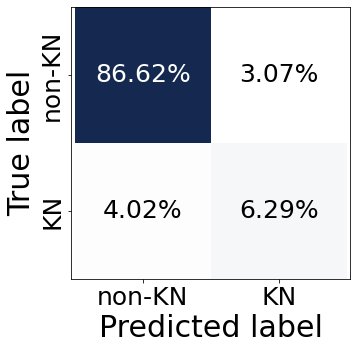

In [24]:
from kndetect.plot_lightcurve import plot_confusion_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plot_confusion_matrix(ax, y_true, y_pred)

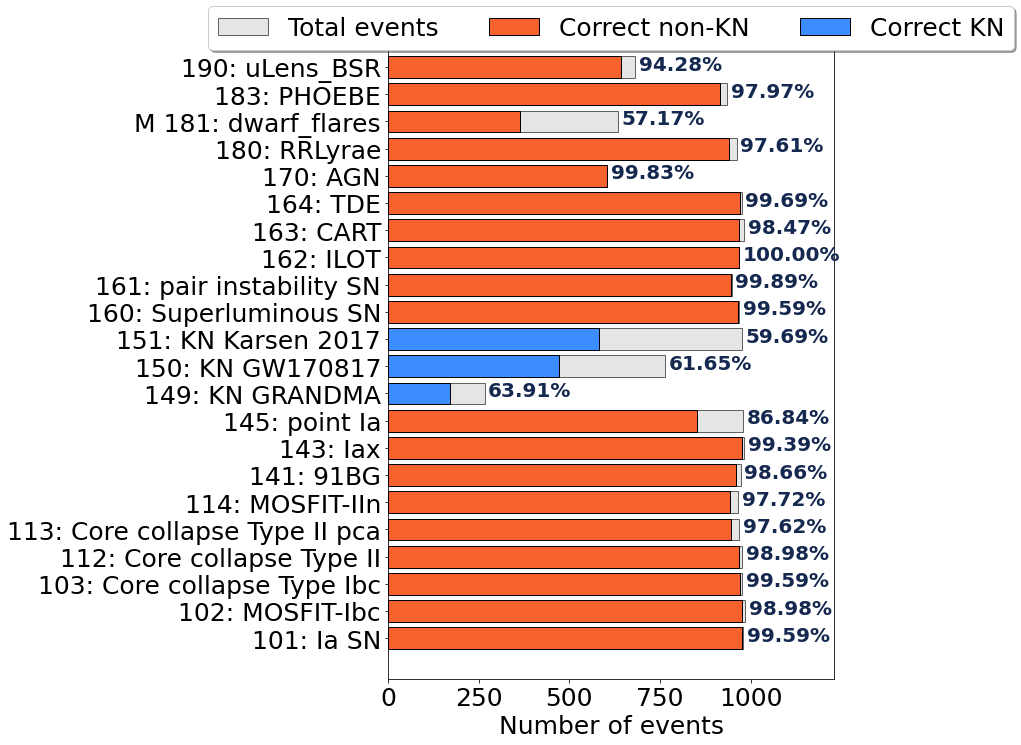

In [25]:
from kndetect.plot_lightcurve import plot_contamination_statistics
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,12))
ax = plt.gca()
plot_contamination_statistics(ax, filtered, [149,150,151])